In [1]:
import rollout_doc_file_processor
import plotter
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [2]:
dir_path = "log/hopper-medium-expert-v2/combo/seed_1_timestamp_25-0825-124532/rollout_docs"

In [3]:
doc_paths = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith('.json')]

In [4]:
docs = rollout_doc_file_processor.load_rollout_docs(doc_paths, cast_to_nparray=False)

In [5]:
# add epoch info to docs
for doc, path in zip(docs, doc_paths):
    match = re.search(r'epoch_(\d+)', path)
    if match:
        epoch = int(match.group(1))
        n = len(doc['obss'])
        doc["epoch"] = [epoch] * n

In [6]:
# consolidate all dicts in docs
consolidated_doc = {}
for doc in docs:
    for key, value in doc.items():
        if key not in consolidated_doc:
            consolidated_doc[key] = []
        consolidated_doc[key] += value
docs = None

In [7]:
consolidated_doc.keys()

dict_keys(['obss', 'next_obss_predicted', 'actions', 'step_nr', 'aleatoric', 'pairwise-diff', 'pairwise-diff_with_std', 'ensemble_std', 'dimensionwise_diff_with_std', 'next_obss_real', 'model_error_l2', 'epoch'])

In [8]:
for k,v in consolidated_doc.items():
    consolidated_doc[k] = np.array(v)

In [9]:
    # doc = rollout_doc_file_processor.load_rollout_docs("log/hopper-medium-expert-v2/combo/seed_1_timestamp_25-0825-124532/rollout_docs/epoch_220_timesteps_219000_rollout_doc.json")
    # doc = doc[0]
    # doc.keys()

doc = consolidated_doc

In [10]:
uncertainty_measures = ['aleatoric', 'pairwise-diff', 'pairwise-diff_with_std', 'ensemble_std', 'dimensionwise_diff_with_std']

Uncertainty Measure: aleatoric                      pearson corr: 0.620572 spearman rank corr: 0.705878
Uncertainty Measure: pairwise-diff                  pearson corr: 0.555896 spearman rank corr: 0.648686
Uncertainty Measure: pairwise-diff_with_std         pearson corr: 0.677675 spearman rank corr: 0.700169
Uncertainty Measure: ensemble_std                   pearson corr: 0.543818 spearman rank corr: 0.688319
Uncertainty Measure: dimensionwise_diff_with_std    pearson corr: 0.668495 spearman rank corr: 0.722645


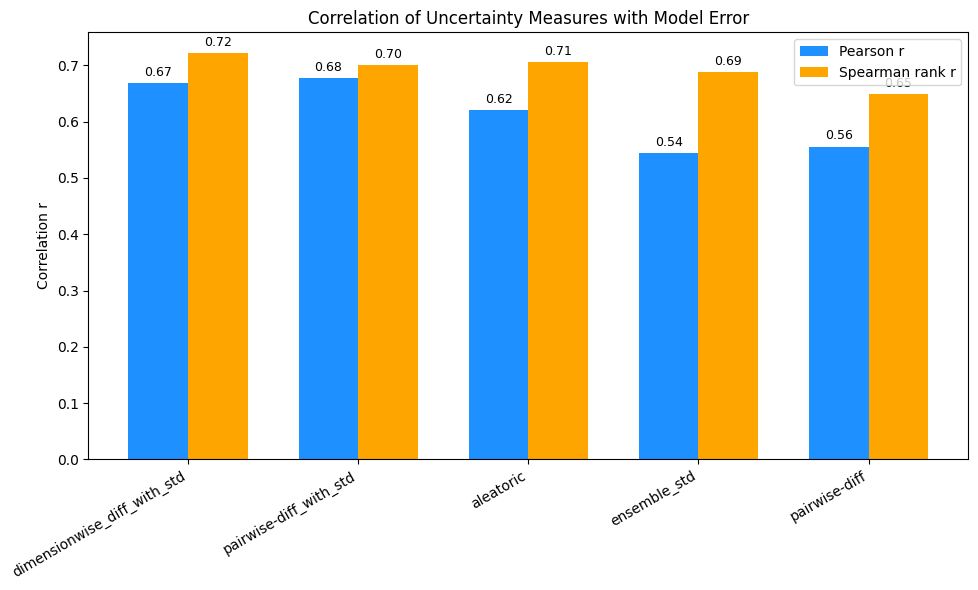

In [11]:
plotter.plot_correlation_bars(doc, uncertainty_measures, error_key='model_error_l2', title='Correlation of Uncertainty Measures with Model Error', print_corr_values=True, fig_size=(10, 6))

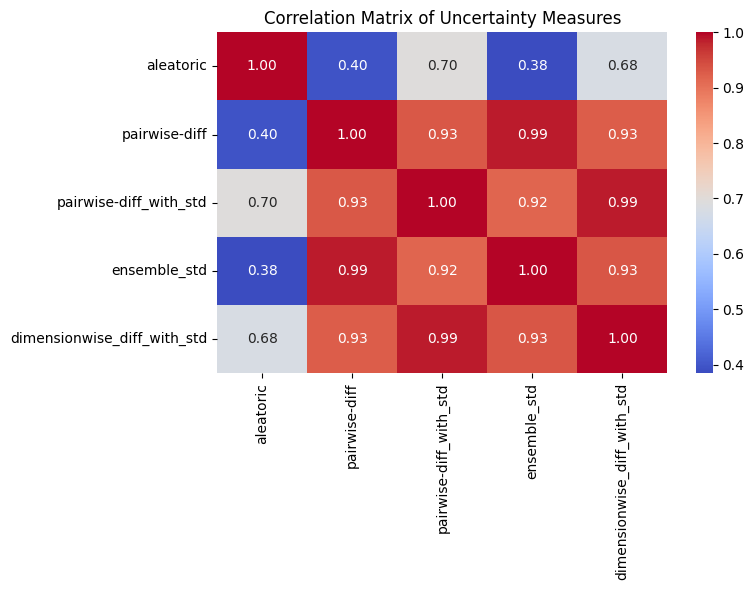

In [12]:
# Prepare data for correlation matrix
uncertainty_data = np.stack([doc[k] for k in uncertainty_measures], axis=1)
corr_matrix = np.corrcoef(uncertainty_data, rowvar=False)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, xticklabels=uncertainty_measures, yticklabels=uncertainty_measures, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Uncertainty Measures")
plt.tight_layout()
plt.show()

<Figure size 600x600 with 0 Axes>

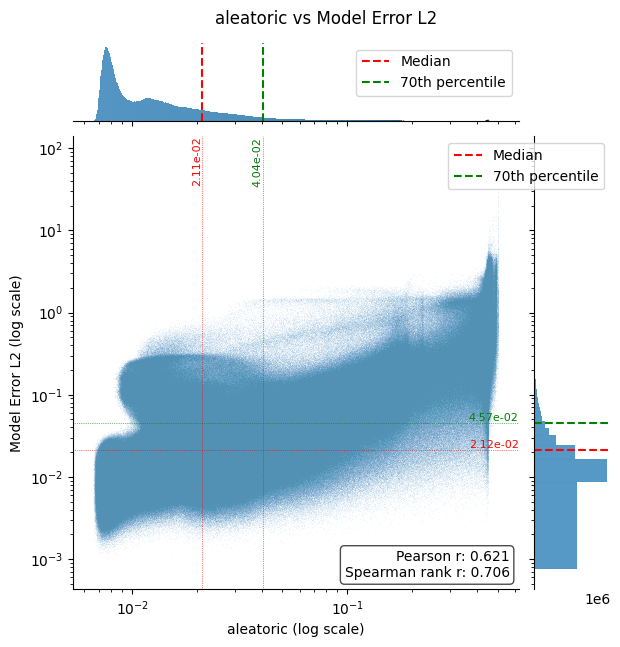

<Figure size 600x600 with 0 Axes>

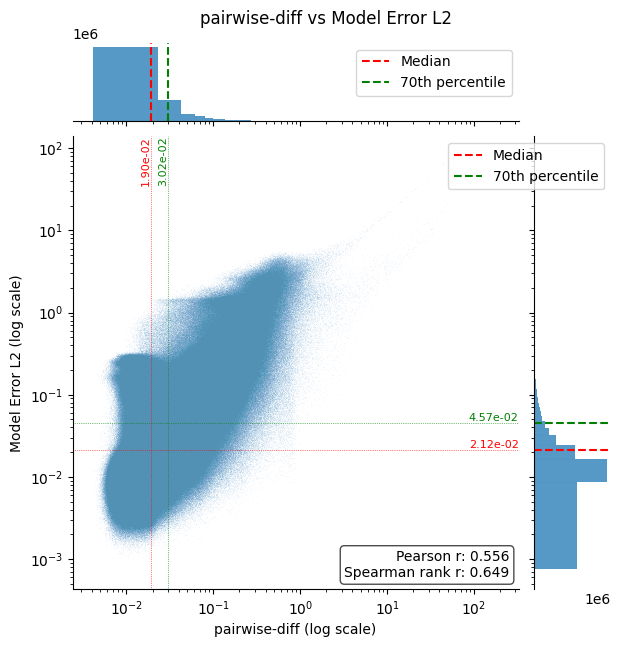

<Figure size 600x600 with 0 Axes>

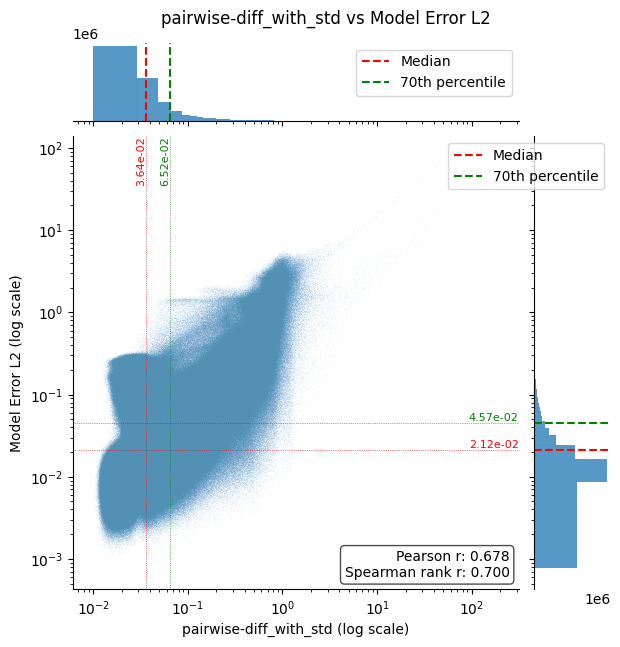

<Figure size 600x600 with 0 Axes>

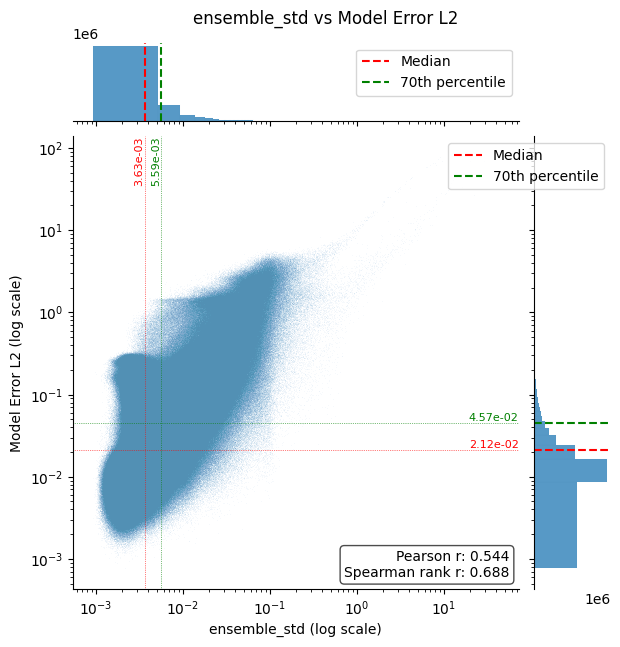

<Figure size 600x600 with 0 Axes>

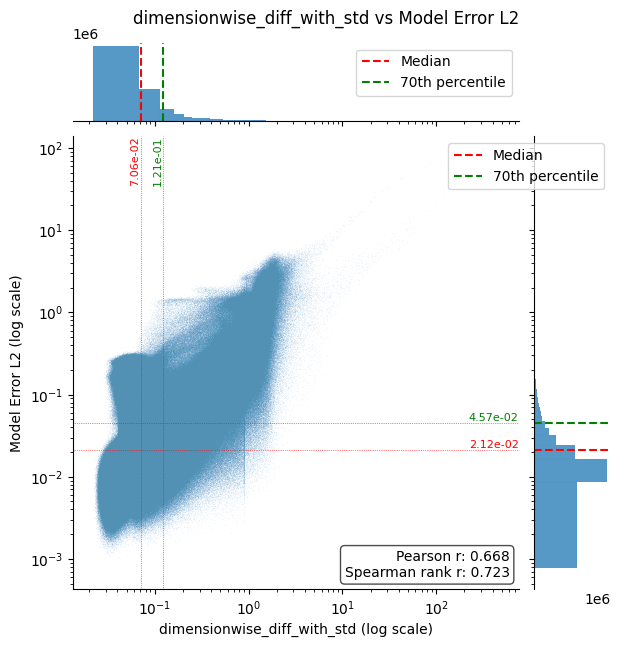

In [13]:
for u in uncertainty_measures:
    plotter.plot_scatter_correlation(x=doc[u], y=doc["model_error_l2"], title=f"{u} vs Model Error L2", xlabel=u, ylabel="Model Error L2", bins=10000, mark_percentile=70, fig_size=(6, 6), points_s=0.5, points_alpha=0.05)

#### Fit OLS Model

In [14]:
unc_data = np.stack([doc[k] for k in uncertainty_measures]).T
target = doc["model_error_l2"]
unc_data.shape, target.shape

((9765792, 5), (9765792,))

In [15]:
# Fit linear regression model
reg_strength = 0.5
beta = np.linalg.inv(unc_data.T @ unc_data + reg_strength) @ unc_data.T @ target
y_hat = unc_data @ beta
beta, y_hat.shape

(array([-0.34928188, -0.06552102,  0.92008606, -7.12479997,  0.54578387]),
 (9765792,))

In [16]:
pearson_y_hat = np.corrcoef(y_hat, doc["model_error_l2"])[0, 1]
spearman_y_hat, _ = spearmanr(y_hat, doc["model_error_l2"])
pearson_y_hat, spearman_y_hat

(0.7118342010186027, 0.7094457805354782)

<Figure size 600x600 with 0 Axes>

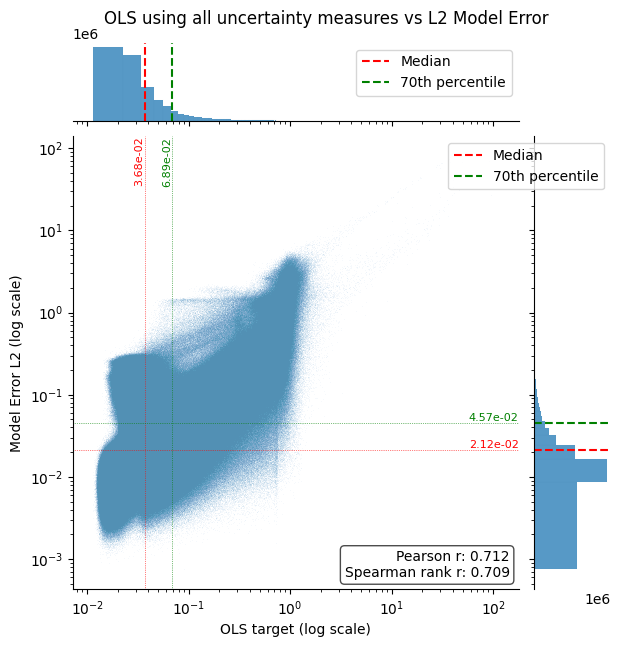

In [17]:
plotter.plot_scatter_correlation(x= y_hat, y=doc["model_error_l2"], title=f"OLS using all uncertainty measures vs L2 Model Error", xlabel="OLS target", ylabel="Model Error L2", bins=10000, mark_percentile=70, fig_size=(6, 6), points_s=0.5, points_alpha=0.05)

## Logistic Regression on all Features as Filter Criterion - Target L2 Error Threshold: 0.1

In [18]:
# Logistic Regression to find criterion to filter model_error > 0.1

threshold = 0.1

targets_log_reg = (doc["model_error_l2"] > threshold).astype(int)
sample_weights = np.clip(np.abs(doc["model_error_l2"] - threshold)**0.5, 0, 2) # clipped sqrt abs distance

targets_log_reg.shape, sample_weights.shape

((9765792,), (9765792,))

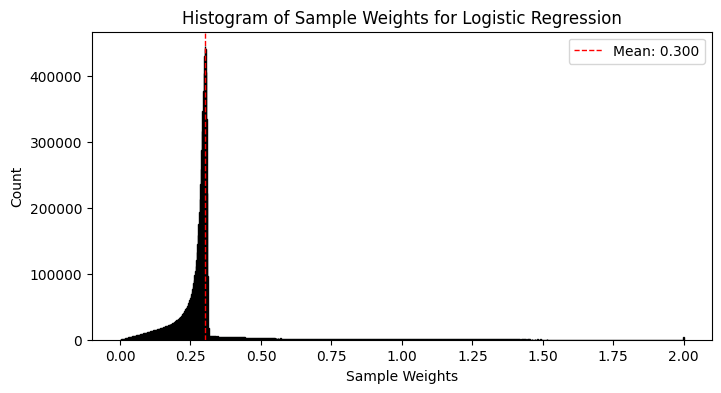

In [19]:
plt.figure(figsize=(8, 4))
plt.hist(sample_weights, bins=1000, color='skyblue', edgecolor='black')
mean_val = np.mean(sample_weights)
plt.axvline(mean_val, color='r', linestyle='--', linewidth=1, label=f"Mean: {mean_val:.3f}")
plt.xlabel("Sample Weights")
plt.ylabel("Count")
plt.title("Histogram of Sample Weights for Logistic Regression")
plt.legend()
plt.show()

In [20]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(unc_data, targets_log_reg, sample_weight=sample_weights)
log_reg.coef_

array([[ -3.14607254,   3.02405944, -11.75425155,   2.41841186,
         16.34442029]])

In [21]:
y_hat_log_reg = log_reg.predict(unc_data)
y_hat_log_reg.shape

(9765792,)

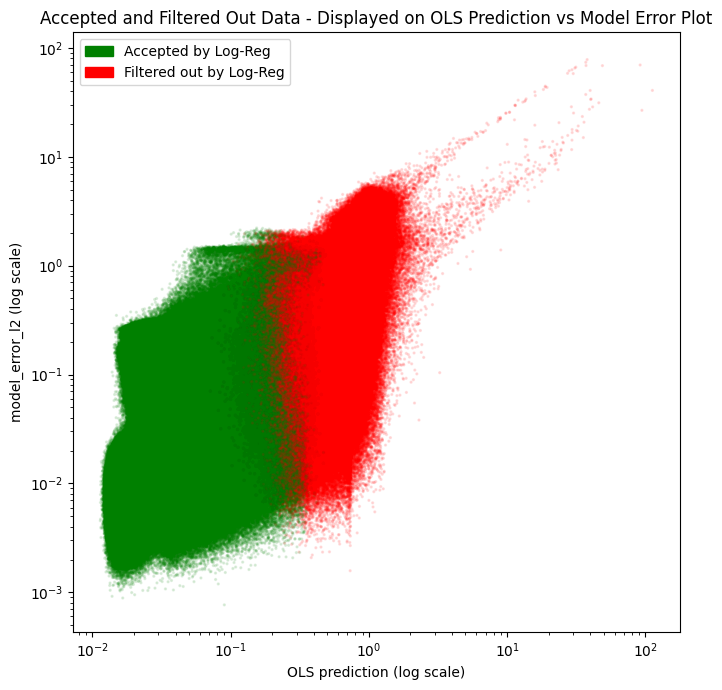

In [22]:
x = y_hat
y = doc["model_error_l2"]

# Prepare colors by y_hat_log_reg
colors = np.where(y_hat_log_reg == 1, "red", "green")

plt.figure(figsize=(7, 7))
plt.scatter(x, y, c=colors, s=2, alpha=0.1, label=None)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("OLS prediction (log scale)")
plt.ylabel("model_error_l2 (log scale)")
plt.title("Accepted and Filtered Out Data - Displayed on OLS Prediction vs Model Error Plot")

# Add legend for colors
import matplotlib.patches as mpatches
plt.legend(handles=[
    mpatches.Patch(color='green', label='Accepted by Log-Reg'),
    mpatches.Patch(color='red', label='Filtered out by Log-Reg')
], loc='upper left')

plt.tight_layout()
plt.show()

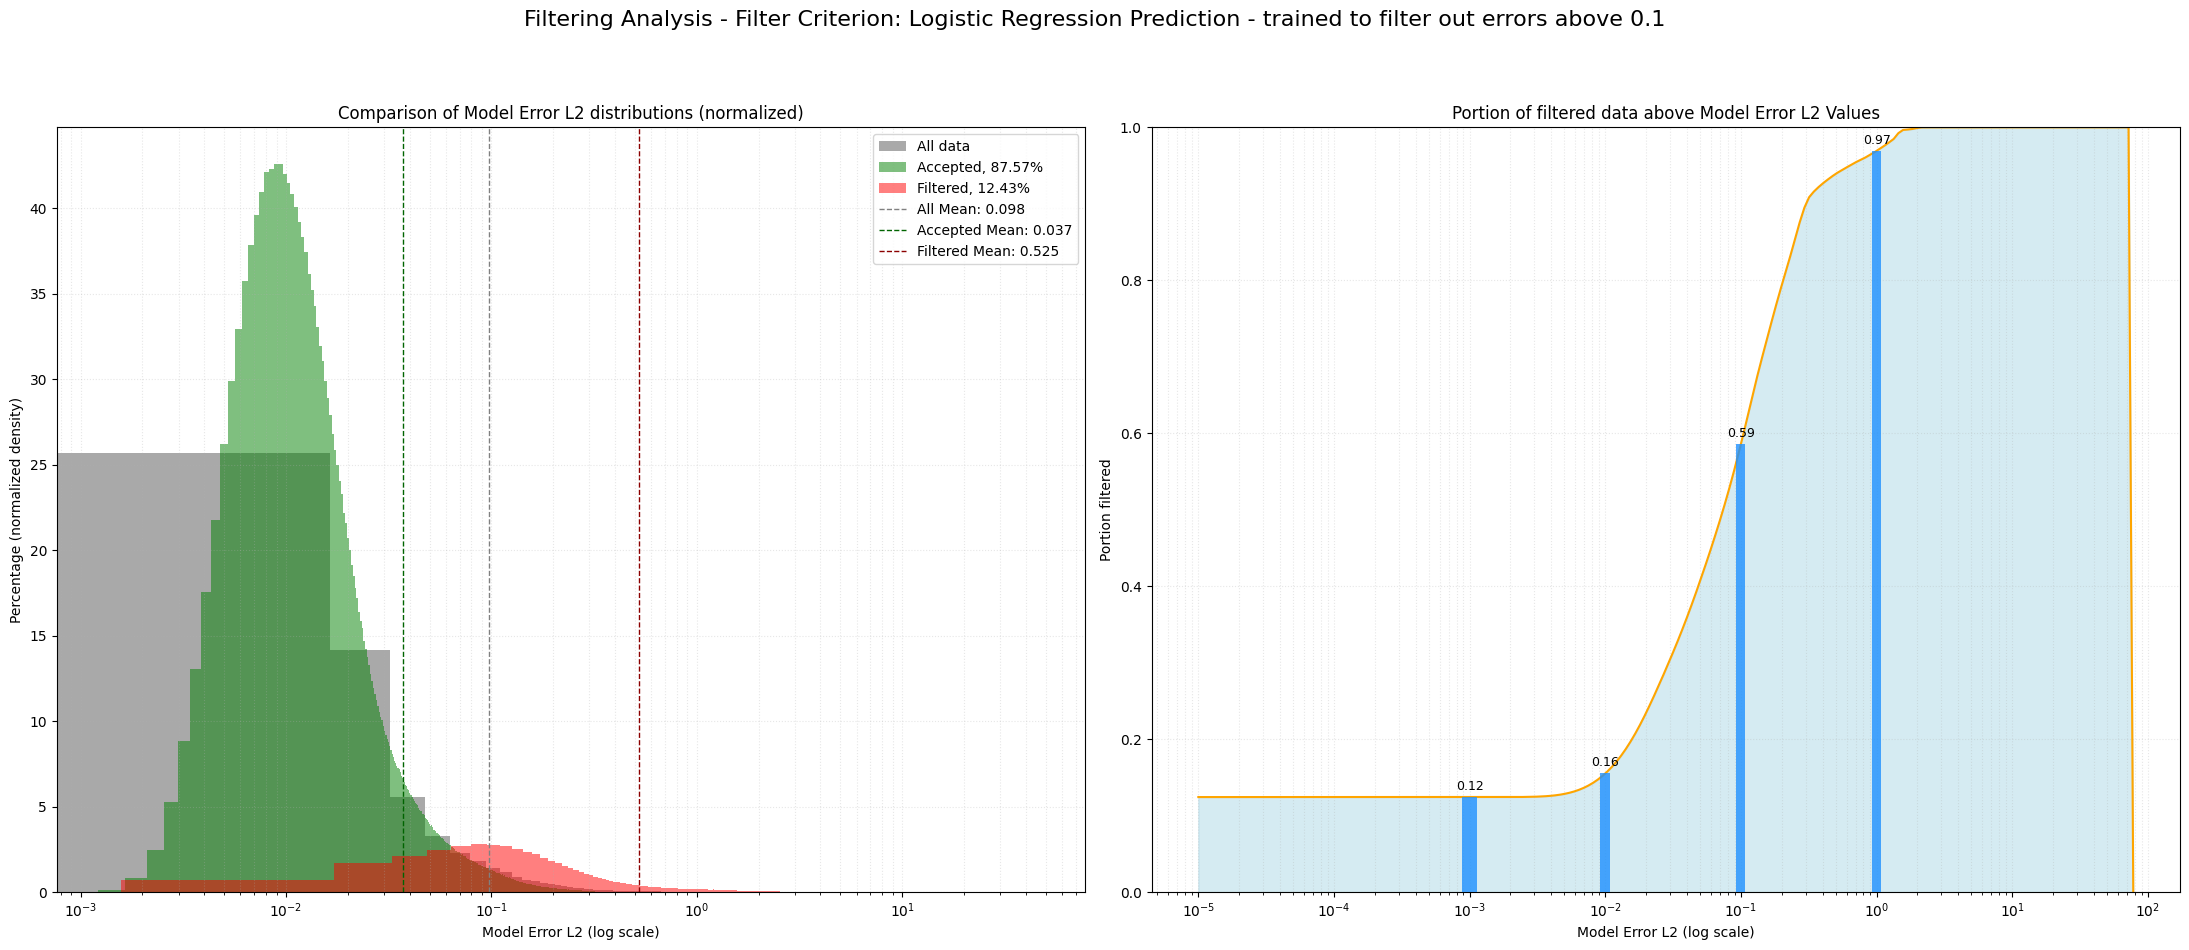

In [23]:
plotter.plot_filtering_analysis(doc, filter_indicator=y_hat_log_reg, bins=5000, fig_size=(22, 9), filter_criterion="Logistic Regression Prediction - trained to filter out errors above 0.1")

### Heuristic Filter Criterion - Filter out iff dimensionwise_diff_with_std > 0.15 OR aleatoric > 0.15

In [24]:
filter_indicator = (doc["dimensionwise_diff_with_std"] > 0.15) | (doc["aleatoric"] > 0.15)
filter_indicator.shape

(9765792,)

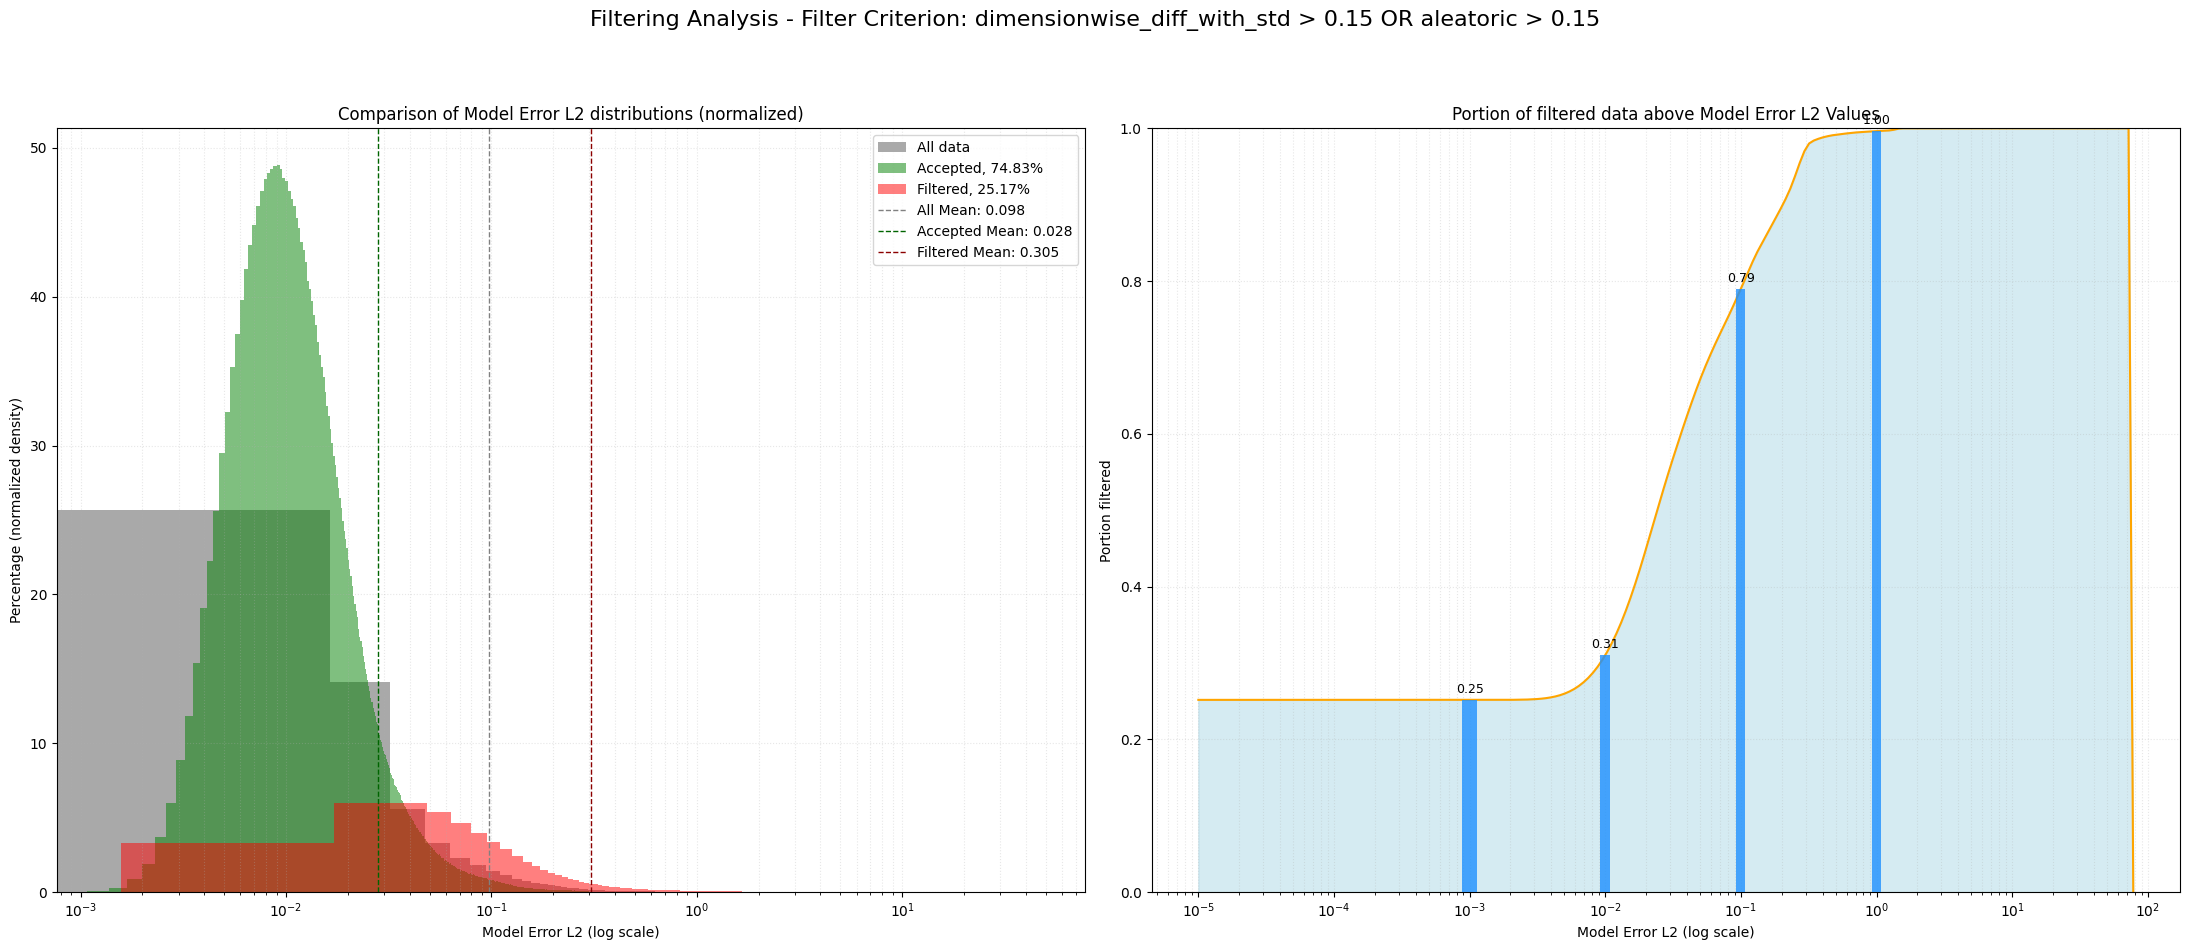

In [25]:
plotter.plot_filtering_analysis(doc, filter_indicator=filter_indicator, bins=5000, fig_size=(22, 9), filter_criterion="dimensionwise_diff_with_std > 0.15 OR aleatoric > 0.15")

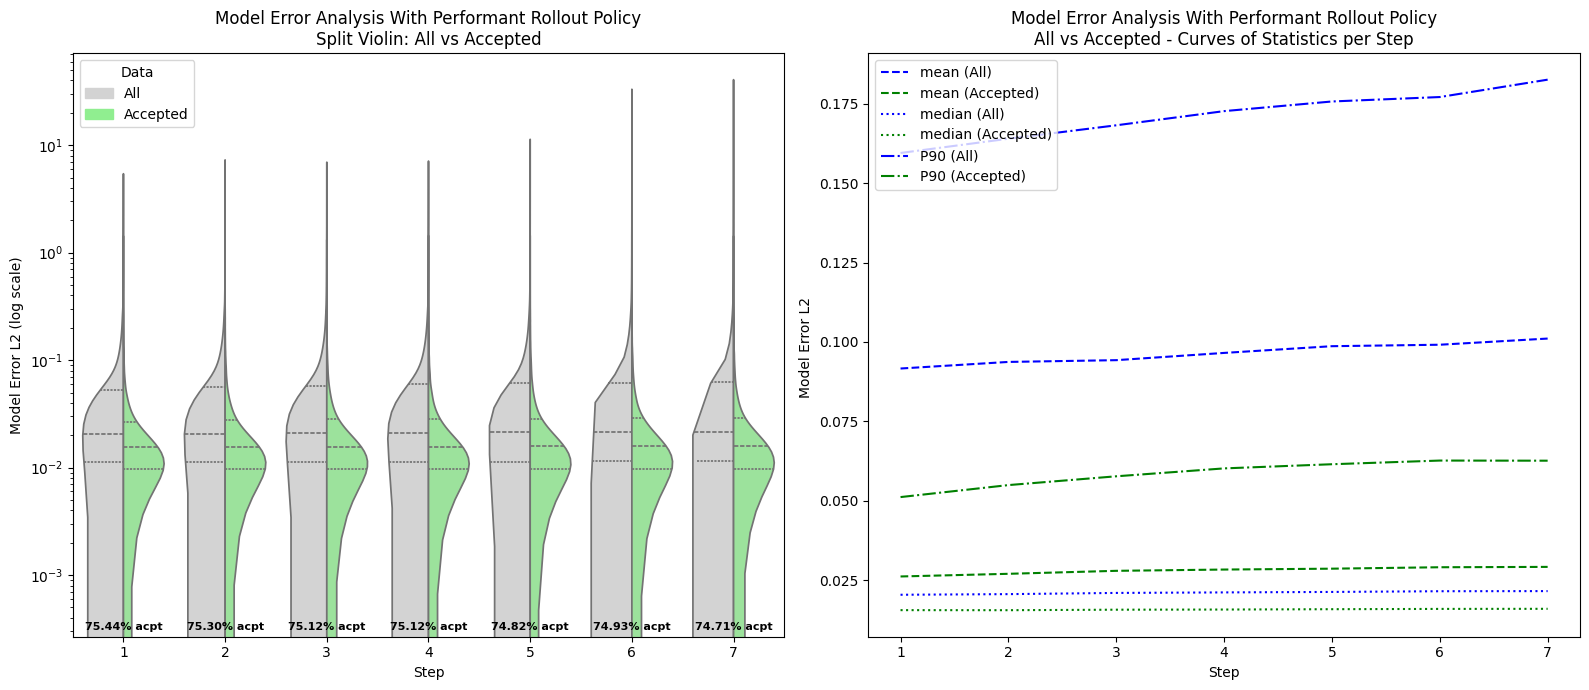

In [26]:
plotter.plot_model_error_all_vs_accepted_per_step(doc, filter_indicator, epoch_vals=[220, 230, 280], title='Model Error Analysis With Performant Rollout Policy', statistics=["mean", "median", "P90"], curves_logscale=False)

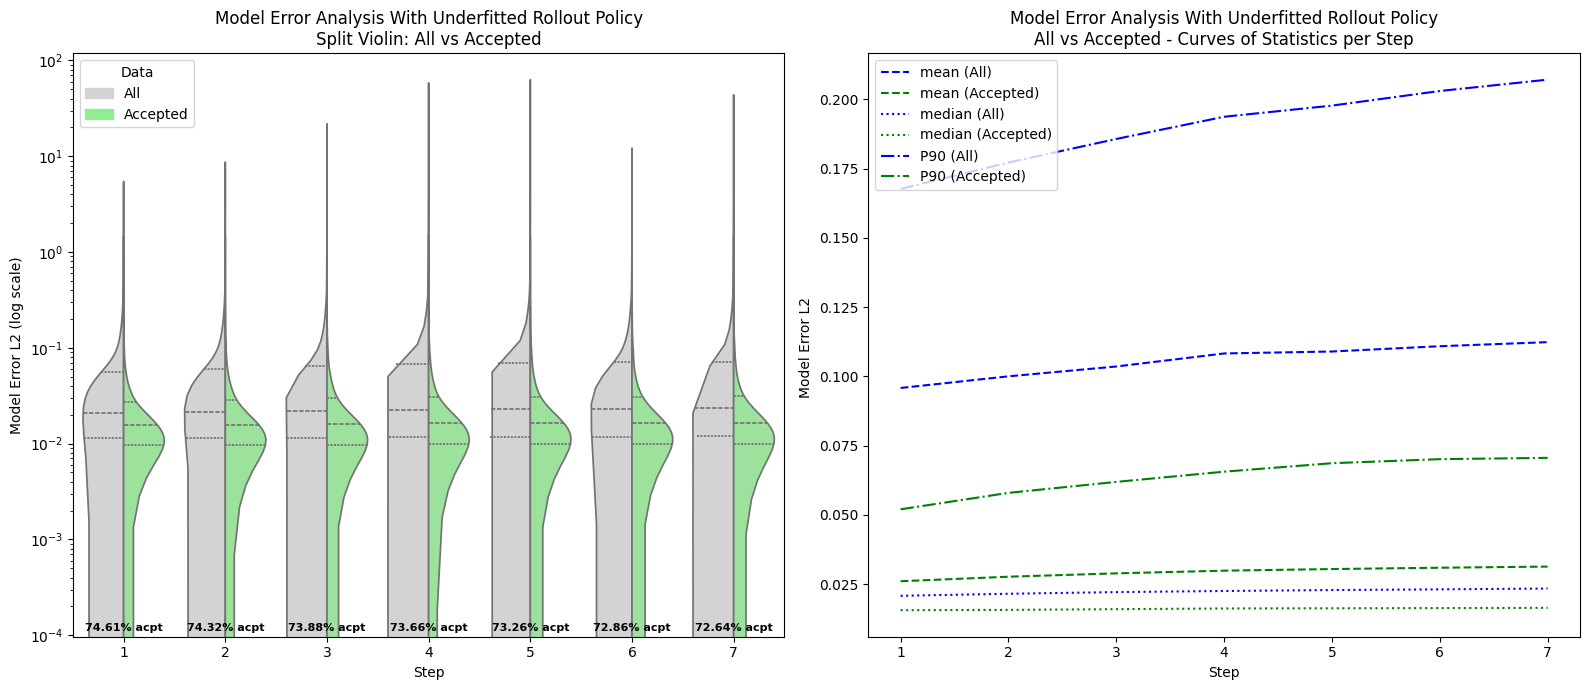

In [27]:
plotter.plot_model_error_all_vs_accepted_per_step(doc, filter_indicator, epoch_vals=[10,20,30], title='Model Error Analysis With Underfitted Rollout Policy', statistics=["mean", "median", "P90"], curves_logscale=False)

=> Model error doesn't change much with rollout policy actor quality (with same dynamics model)